In [14]:
# --- 1. Imports ---
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# --- 2. Load processed news data ---
news_df = pd.read_csv("../data/processed/news_with_topics.csv")

# Ensure datetime column
news_df['date'] = pd.to_datetime(news_df['date'], utc=True)
news_df['date_only'] = news_df['date'].dt.date

In [17]:
# --- 3. Compute sentiment scores ---
import swifter

news_df['sentiment_score'] = news_df['headline'].swifter.apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Save for reference
news_df.to_csv("../data/processed/news_with_sentiment.csv", index=False)

# Aggregate daily sentiment
daily_sentiment = news_df.groupby('date_only')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'date_only':'Date', 'sentiment_score':'avg_sentiment'}, inplace=True)

c:\Users\Dawit\Documents\week1-news-sentiment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply: 100%|██████████| 1407328/1407328 [08:21<00:00, 2807.30it/s]


In [19]:
# --- 4. Load stock data ---
stock_files = ["AAPL.csv", "AMZN.csv", "GOOG.csv", "META.csv", "MSFT.csv", "NVDA.csv"]
processed_stock_path = "../data/raw/stocks"  # adjust path if needed

def compute_daily_returns(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['daily_return'] = df['Close'].pct_change()
    return df

stock_data = {}
for file in stock_files:
    symbol = file.split(".")[0]
    df_stock = pd.read_csv(f"{processed_stock_path}/{file}")
    df_stock = compute_daily_returns(df_stock)
    stock_data[symbol] = df_stock


In [21]:
import pandas as pd

correlation_results = {}

for symbol, df_stock in stock_data.items():
    # Ensure 'Date' is datetime in both DataFrames
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
    
    # Merge stock data with daily average sentiment
    merged_df = pd.merge(df_stock, daily_sentiment, on='Date', how='inner')
    
    # Compute correlation between daily returns and average sentiment
    corr = merged_df['daily_return'].corr(merged_df['avg_sentiment'])
    
    correlation_results[symbol] = corr

# Convert results to a DataFrame for easier display
corr_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['correlation'])
print(corr_df)


      correlation
AAPL    -0.001783
AMZN    -0.023405
GOOG     0.009605
META    -0.005365
MSFT    -0.009940
NVDA     0.005827


In [22]:
# --- 6. Summary table ---
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Stock', 'Correlation'])
correlation_df.sort_values('Correlation', ascending=False, inplace=True)
correlation_df

,Stock,Correlation
2,GOOG,0.009605
5,NVDA,0.005827
0,AAPL,-0.001783
3,META,-0.005365
4,MSFT,-0.009940
1,AMZN,-0.023405


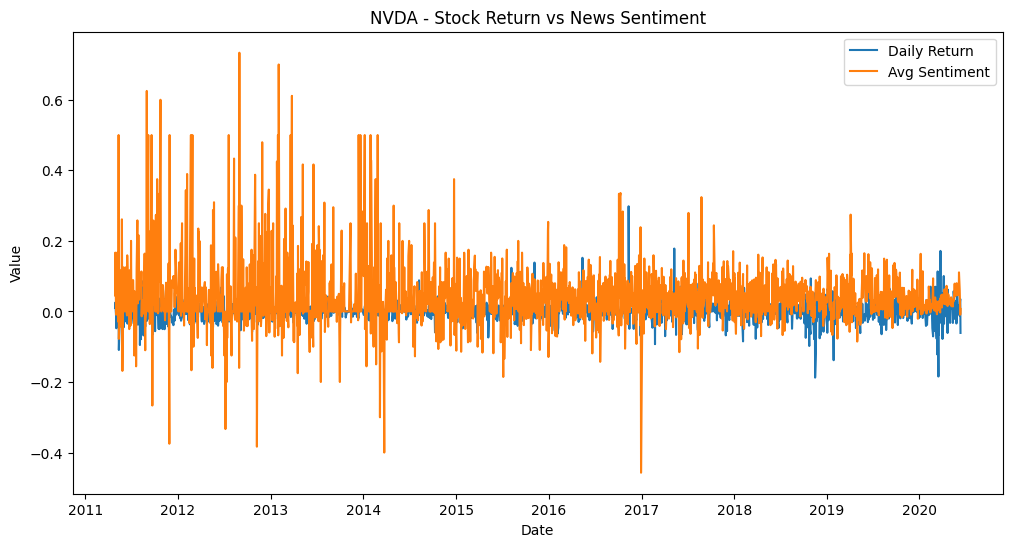

In [ ]:
# --- 7. Visualization ---

plt.figure(figsize=(12,6))
plt.plot(merged_df['Date'], merged_df['daily_return'], label='Daily Return')
plt.plot(merged_df['Date'], merged_df['avg_sentiment'], label='Avg Sentiment')
plt.title(f"{symbol} - Stock Return vs News Sentiment")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


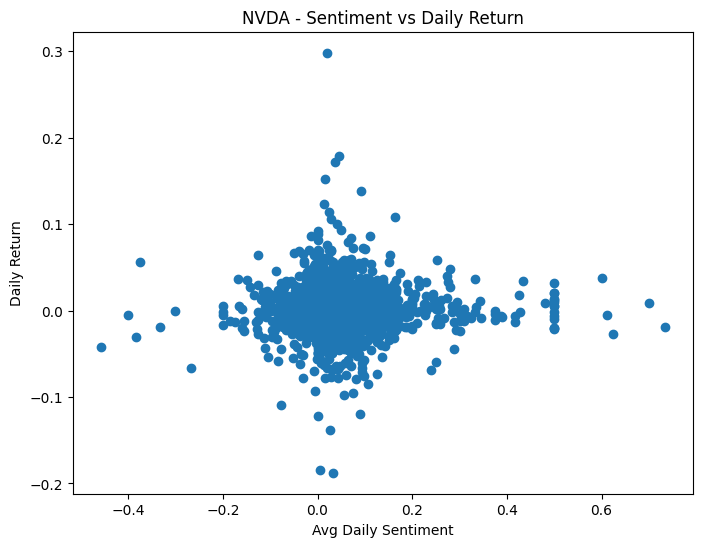

In [24]:
# Scatter plot of sentiment vs daily return
plt.figure(figsize=(8,6))
plt.scatter(merged_df['avg_sentiment'], merged_df['daily_return'])
plt.title(f"{symbol} - Sentiment vs Daily Return")
plt.xlabel("Avg Daily Sentiment")
plt.ylabel("Daily Return")
plt.show()


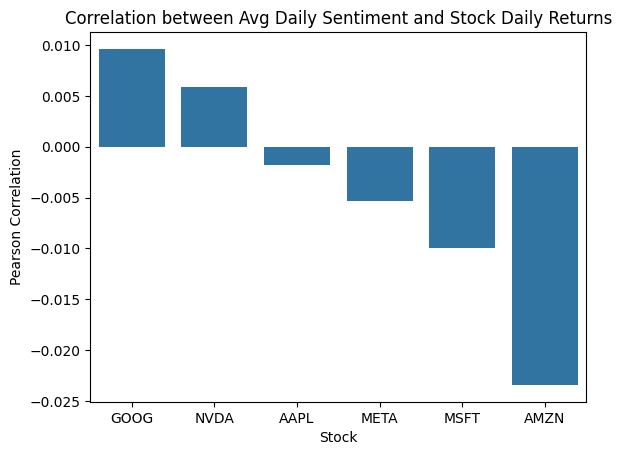

In [25]:
# Bar plot of correlations

sns.barplot(x='Stock', y='Correlation', data=correlation_df)
plt.title("Correlation between Avg Daily Sentiment and Stock Daily Returns")
plt.ylabel("Pearson Correlation")
plt.show()
